In [1]:
import pandas as pd
import numpy as np
import os
import shutil
from pylabel import importer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

### 1. Merge dataframes
Take initial csv files for two parts of data, preprocess them and merge

In [38]:
df_add = pd.read_csv('/Users/aleksandr/Desktop/hacks/rosneft/data/additional/new_train.csv')
df_for_part = pd.read_csv('/Users/aleksandr/Desktop/hacks/rosneft/data/for_participants/train.csv')

In [39]:
df_for_part.head(2)

,filename,view,x_c,y_c,w,h,class_label,image_width,image_height
0,d7373069-7d87-471b-a228-9fdba9a0ac8a.jpg,aerial,0.609664,0.772135,0.021026,0.027488,reindeer,5184,3456
1,d7373069-7d87-471b-a228-9fdba9a0ac8a.jpg,aerial,0.663870,0.770689,0.017940,0.035012,reindeer,5184,3456


In [40]:
df_add.head(2)

,filename,x_c,y_c,w,h,class_label,image_width,image_height,private_lb
0,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.010127,0.137731,0.020255,0.057292,reindeer,5184,3456,False
1,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.036555,0.177662,0.038387,0.062500,reindeer,5184,3456,False


In [41]:
df_add['view'] = 'aerial'
df_add = df_add.drop(labels='private_lb', axis=1)

In [42]:
df_add.head(2)

,filename,x_c,y_c,w,h,class_label,image_width,image_height,view
0,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.010127,0.137731,0.020255,0.057292,reindeer,5184,3456,aerial
1,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.036555,0.177662,0.038387,0.062500,reindeer,5184,3456,aerial


In [43]:
df = pd.concat([df_add, df_for_part], axis=0)
df.reset_index(inplace=True, drop=True)
df

,filename,x_c,y_c,w,h,class_label,image_width,image_height,view
0,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.010127,0.137731,0.020255,0.057292,reindeer,5184,3456,aerial
1,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.036555,0.177662,0.038387,0.062500,reindeer,5184,3456,aerial
2,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.075424,0.297164,0.042438,0.068866,reindeer,5184,3456,aerial
3,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.041570,0.295428,0.035301,0.054398,reindeer,5184,3456,aerial
4,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.076292,0.482928,0.029514,0.061921,reindeer,5184,3456,aerial
...,...,...,...,...,...,...,...,...,...
24887,9f26e5da-dfda-4681-a5e7-b250adb1260a.jpg,0.696950,0.587582,0.156863,0.113725,reindeer,5568,3712,ground
24888,9f26e5da-dfda-4681-a5e7-b250adb1260a.jpg,0.746187,0.596078,0.129847,0.078431,reindeer,5568,3712,ground
24889,9f26e5da-dfda-4681-a5e7-b250adb1260a.jpg,0.854248,0.618301,0.068845,0.070588,reindeer,5568,3712,ground
24890,9f26e5da-dfda-4681-a5e7-b250adb1260a.jpg,0.926911,0.621256,0.137482,0.131401,reindeer,5568,3712,ground


In [44]:
MAPPING = {
    'fawn': 0,
    'reindeer': 1
}

In [45]:
df['class_index'] = df['class_label'].apply(lambda label: MAPPING[label])

In [46]:
df.head(2)

,filename,x_c,y_c,w,h,class_label,image_width,image_height,view,class_index
0,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.010127,0.137731,0.020255,0.057292,reindeer,5184,3456,aerial,1
1,8525df74-ba0e-40ef-bba3-9cb9c93f5c24.jpg,0.036555,0.177662,0.038387,0.062500,reindeer,5184,3456,aerial,1


In [48]:
df.class_label.value_counts()

reindeer    21062
fawn         3830
Name: class_label, dtype: int64

In [12]:
df.to_csv('/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/all_annotations.csv')

In [13]:
image_names = os.listdir(path='/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/images')

In [14]:
images = df.filename.unique()

In [15]:
delta = [img for img in image_names if img not in images]
len(delta)

42

### 2. Create YOLOv5 annotations

In [16]:
def yolo_ann_from_single_img_df(df, img_name, anno_base_path):
    filename, ext = os.path.splitext(img_name)
    anno_file = filename + '.txt'
    file = os.path.join(anno_base_path, anno_file)
    with open(file, 'w') as f:
        if len(df) == 0:
            return
        for idx, row in df.iterrows():
            if img_name == '3f43d3cb-4588-480c-8381-34cef8c11252.jpg':
                data = f'{MAPPING["reindeer"]} {row.x_c} {row.y_c} {row.w} {row.h}\n'
            else:
                data = f'{row.class_index} {row.x_c} {row.y_c} {row.w} {row.h}\n'
            f.write(data)
            
def yolo_ann(df, all_imgs, anno_base_path):
    for img in tqdm(all_imgs):
        object_df = df.loc[df.filename==img]
        yolo_ann_from_single_img_df(object_df, img, anno_base_path)

In [17]:
yolo_ann(df, image_names, '/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/annotation_yolo')

### 3. Convert to COCO annotations

In [11]:
yoloclasses = ('fawn', 'reindeer')
path_to_images = '/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/images'
path_to_annotations = '/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/annotation_yolo'
dataset = importer.ImportYoloV5(path=path_to_annotations, path_to_images=path_to_images, 
                                cat_names=yoloclasses, img_ext='jpg', name='dataset')

In [22]:
dataset.df.head(3)

,img_folder,img_filename,img_path,img_id,img_width,img_height,img_depth,ann_segmented,ann_bbox_xmin,ann_bbox_ymin,...,ann_area,ann_segmentation,ann_iscrowd,ann_pose,ann_truncated,ann_difficult,cat_id,cat_name,cat_supercategory,split
id,,,,,,,,,,,,,,,,,,,,,
0,/Users/aleksandr/Desktop/hacks/rosneft/data/tr...,85eaf52f-894b-415e-bd53-f842f234b671.jpg,NaN,0,5568,3712,3,NaN,2196.996384,1887.269888,...,136474.216247,NaN,0,NaN,NaN,NaN,1,reindeer,NaN,NaN
1,/Users/aleksandr/Desktop/hacks/rosneft/data/tr...,85eaf52f-894b-415e-bd53-f842f234b671.jpg,NaN,0,5568,3712,3,NaN,2546.778144,2063.218688,...,148222.420569,NaN,0,NaN,NaN,NaN,1,reindeer,NaN,NaN
2,/Users/aleksandr/Desktop/hacks/rosneft/data/tr...,85eaf52f-894b-415e-bd53-f842f234b671.jpg,NaN,0,5568,3712,3,NaN,2713.002432,2037.255104,...,172111.138938,NaN,0,NaN,NaN,NaN,1,reindeer,NaN,NaN


In [13]:
dataset.df.ann_iscrowd = 0
dataset.df.ann_iscrowd

id
0        0
1        0
2        0
3        0
4        0
        ..
24887    0
24888    0
24889    0
24890    0
24891    0
Name: ann_iscrowd, Length: 24892, dtype: int64

In [14]:
dataset.export.ExportToCoco('/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/coco_annotations.json')

['/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/coco_annotations.json']

### 4. Create train and test datasets

In [37]:
train_images, test_images = train_test_split(image_names, test_size=0.15, shuffle=True)

In [38]:
test_delta = [img for img in test_images if img not in images]
print(f'test size: {len(test_images)}, pictures with no deers amount in test: {len(test_delta)}')

test size: 87, pictures with no deers amount in test: 9


In [15]:
all_images_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/images'
all_yolo_ann_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/all_data/annotation_yolo/'

test_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/test'
test_images_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/test/data'
test_yolo_ann_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/test/annotation_yolo'

train_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/train'
train_images_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/train/data'
train_yolo_ann_path = '/Users/aleksandr/Desktop/hacks/rosneft/data/train/annotation_yolo'

#### 4.1 Test

In [ ]:
for img in tqdm(test_images):
    filename, _ = os.path.splitext(img)
    yolo_annotation = filename + '.txt'
    shutil.copy(os.path.join(all_images_path, img), os.path.join(test_images_path, img))
    shutil.copy(os.path.join(all_yolo_ann_path, yolo_annotation), os.path.join(test_yolo_ann_path, yolo_annotation))

In [16]:
yoloclasses = ('fawn', 'reindeer')
dataset = importer.ImportYoloV5(path=test_yolo_ann_path, path_to_images=test_images_path, 
                                cat_names=yoloclasses, img_ext='jpg', name='dataset')

In [17]:
dataset.df.ann_iscrowd = 0

In [18]:
dataset.export.ExportToCoco(os.path.join(test_path, 'coco_annotations.json'))

['/Users/aleksandr/Desktop/hacks/rosneft/data/test/coco_annotations.json']

#### 4.2 Train

In [45]:
for img in tqdm(train_images):
    filename, _ = os.path.splitext(img)
    yolo_annotation = filename + '.txt'
    shutil.copy(os.path.join(all_images_path, img), os.path.join(train_images_path, img))
    shutil.copy(os.path.join(all_yolo_ann_path, yolo_annotation), os.path.join(train_yolo_ann_path, yolo_annotation))

In [19]:
yoloclasses = ('fawn', 'reindeer')
dataset = importer.ImportYoloV5(path=train_yolo_ann_path, path_to_images=train_images_path, 
                                cat_names=yoloclasses, img_ext='jpg', name='dataset')

In [20]:
dataset.df.ann_iscrowd = 0

In [21]:
dataset.export.ExportToCoco(os.path.join(train_path, 'coco_annotations.json'))

['/Users/aleksandr/Desktop/hacks/rosneft/data/train/coco_annotations.json']

<AxesSubplot:>

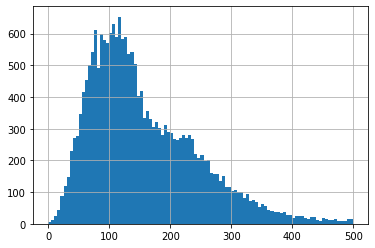

In [36]:
dataset.df.loc[dataset.df.ann_bbox_width < 500, 'ann_bbox_width'].hist(bins=100)